In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Main script used for training."""
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.models import load_model
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import model as mod
import dataset
from dataset import pyplot_piano_roll
from pathlib import Path
from plotter import smooth
import time
import math
import ev_metrics
import pypianoroll
from pypianoroll import Multitrack, Track
import numpy as np
import copy

# P = Path(__file__).parent.absolute()
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook

PLOTS = P / 'plots'  # Plots path
FS = 24  # Sampling frequency. 10 Hz = 100 ms
# Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 12
D = "data"  # Dataset (synth or data)
CROP = [21, 109]  # Crop plots
TRANS = 0

### Load model

In [3]:
MODEL = 'model-RNN-12-10'

model = load_model(filepath=str(P / MODEL),
                   custom_objects=None,
                   compile=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 32)            3872      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
Output (Dense)               (None, 880)               29040     
Total params: 34,992
Trainable params: 34,992
Non-trainable params: 0
_________________________________________________________________


### Load midi file

In [18]:
FILE = 'pattern4BIS.mid'

test_list = [P / 'tests' / FILE]
print("Total number of MIDI files:", len(test_list))
test = dataset.Dataset(test_list, P / D,  fs=FS, bl=0)
test.build_dataset("test", step=st, t_step=num_ts, steps=st, down=DOWN)
print("Done")
print("Shape: ", test.dataset[0].shape)

Total number of MIDI files: 1
Building test dataset (1 files)
Done
Shape:  (54, 10, 88)


### Make predictions

In [19]:
predictions = model.predict(x=test.dataset[0])

### Build baseline

In [20]:
baseline = dataset.Dataset(test_list, P / D,  fs=FS, bl=1)
baseline.build_dataset("baseline", step=st, t_step=num_ts, steps=st, down=DOWN)

Building baseline dataset (1 files)


### Make piano rolls

In [21]:
newpiano = copy.deepcopy(predictions)
L = int(predictions.shape[1]/88)
for t in range(L):
    newpiano[newpiano.shape[0]-L+t, :88] = predictions[newpiano.shape[0]-L, 88*t:88*(t+1)]
    
a = copy.deepcopy(test.dataset[1][:, :])
L = int(test.dataset[1][:, :].shape[1]/88)
for t in range(L):
    a[a.shape[0]-L+t, :88] = test.dataset[1][a.shape[0]-L, 88*t:88*(t+1)]
    
a = pd.DataFrame(test.dataset[0][:, 0, :])
b = pd.DataFrame(newpiano[-num_ts:, :88])
b2 = pd.DataFrame(test.dataset[1][-num_ts:, :88])

c = pd.concat([a, b]).values
d = pd.concat([a, b2]).values

### Visualise piano rolls

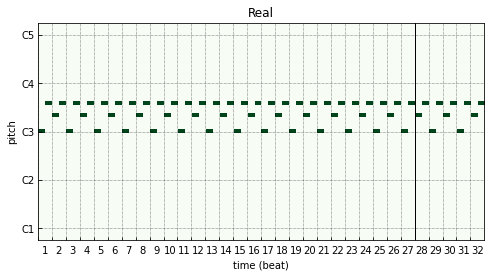

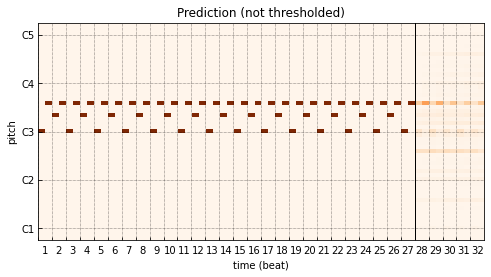

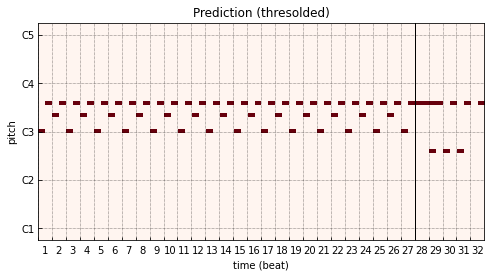

In [25]:
th = 0.16

C = copy.deepcopy(c)
C[C > th] = 1
C[C < th] = 0

plt.rcParams["figure.figsize"] = (8, 4)
ax1 = pyplot_piano_roll(d, cmap="Greens", db=[d.shape[0]-L-0.5], br=2)
plt.title('Real')
plt.ylim(33, 87)
# plt.xlim([50, 71])
plt.savefig(PLOTS / 'bach846' / 'real.eps')

pyplot_piano_roll(c, cmap="Oranges", db=[d.shape[0]-L-0.5], br=2)
plt.title('Prediction (not thresholded)')
plt.ylim(33, 87)
# plt.xlim([50, 71])
plt.savefig(PLOTS / 'bach846' / 'not-thresh.eps')

pyplot_piano_roll(C, cmap="Reds", db=[d.shape[0]-L-0.5], br=2)
plt.title('Prediction (thresolded)')
plt.ylim(33, 87)
# plt.xlim([50, 71])
plt.savefig(PLOTS / 'bach846' / 'thresh.eps')